### Analyzing a bike trip from Lyon to amsterdam 

We parse Strava gpx files and see what stats and plot we can make.

In [235]:
import gpxpy
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

PATH = '/home/diederik/ams/pyprojects/geospatial_analysis/data/strava/'
p = Path(PATH_)
files = list(p.rglob('*.gpx*'))

In [160]:
def load_bike_data(gpx_files_path, filter=""):
    files = list(p.rglob('*.gpx*'))
    
    track_data = []
    
    for file_idx, file in enumerate(files): 
        gpx = gpxpy.parse(open(file, 'r'))
        # Loop through tracks
        for track_idx, track in enumerate(gpx.tracks):
            track_name = track.name
            track_time = track.get_time_bounds().start_time
            track_length = track.length_3d()
            track_duration = track.get_duration()
            track_speed = track.get_moving_data().max_speed
            
            for i, segment in enumerate(track.segments):
                segment_length = segment.length_3d()
                for point_idx, point in enumerate(segment.points):
                    track_data.append([file_idx, os.path.basename(file), track_idx, track_name, 
                                     track_time, track_length, track_duration, track_speed, 
                                     i, segment_length, point.time, point.latitude, 
                                     point.longitude, point.elevation, segment.get_speed(i)])
    return track_data

In [173]:
data = load_bike_data(gpx_files_path=PATH, filter="")
df = pd.DataFrame(data, columns=['file_index', 'file_name', 'index', 'etappe',
                              'time', 'length', 'duration', 'max_speed',
                              'segment_index', 'segment_length', 'point_time', 'lat',
                              'lon', 'elev', 'speed'])
# to geopandas
from shapely.geometry import Point
df = gpd.GeoDataFrame(df, crs = {'init': 'epsg:4326'})
df['geometry'] = df.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)

In [175]:
cols = ['file_index', 'time', 'length', 'duration', 'max_speed']
tracks = df[cols].copy()
tracks['length'] /= 1e3
tracks.drop_duplicates(inplace=True)
tracks.head()

,file_index,time,length,duration,max_speed
0,0,2018-08-09 04:26:22,212.903315,43775,13.268900
7034,1,2018-08-07 04:58:13,117.330675,18500,13.942298
10770,2,2018-07-30 04:13:28,126.082312,34595,16.168227
18297,3,2018-07-31 04:35:01,219.450487,40086,16.117601
26140,4,2018-07-28 04:18:05,166.033596,28797,13.682021


In [178]:
df.etappe.value_counts()

Étape 7# Bâle - Saint Dié des Vosges                    7859
Étape 4# Sion - Locarno                                 7843
Étape 3# Aoste - Sion                                   7527
Étape 5# Locarno - Lucerne : St Gotthard via Tremola    7355
Étape 2# Albertville - Aoste                            7102
Étape 11# Achouffe - Eindhoven                          7034
Étape 10# Verdun - Achouffe                             6375
Étape 1 # Lyon - Albertville                            5823
Étape 6# Lucerne - Bâle et la canicule                  4276
Étape 12# Eindhoven - Amsterdam !!! XXX !!!             3773
Étape 9# Nancy - Verdun                                 3736
Étape 8# Saint Dié - Nancy                              3544
Name: etappe, dtype: int64

In [181]:
tracks['week'] = tracks['time'].apply(lambda x: x.week)
tracks['day'] = tracks['time'].apply(lambda x: x.day)
tracks_grouped = tracks.groupby(['week','day'])
tracks_grouped.describe()

duration                                                            \
            count     mean std      min      25%      50%      75%      max   
week day                                                                      
30   28       1.0  28797.0 NaN  28797.0  28797.0  28797.0  28797.0  28797.0   
     29       1.0  32797.0 NaN  32797.0  32797.0  32797.0  32797.0  32797.0   
31   2        1.0  34592.0 NaN  34592.0  34592.0  34592.0  34592.0  34592.0   
     3        1.0  22924.0 NaN  22924.0  22924.0  22924.0  22924.0  22924.0   
     5        1.0  39094.0 NaN  39094.0  39094.0  39094.0  39094.0  39094.0   
     30       1.0  34595.0 NaN  34595.0  34595.0  34595.0  34595.0  34595.0   
     31       1.0  40086.0 NaN  40086.0  40086.0  40086.0  40086.0  40086.0   
32   6        1.0  22572.0 NaN  22572.0  22572.0  22572.0  22572.0  22572.0   
     7        1.0  18500.0 NaN  18500.0  18500.0  18500.0  18500.0  18500.0   
     8        1.0  35954.0 NaN  35954.0  35954.0  35954.0  35954.0  35954.0   
     9        1.0  43775.0 NaN  43775.0  43775.0  43775.0  43775.0  43775.0   
     10       1.0  21290.0 NaN  21290.0  21290.0  21290.0  21290.0  21290.0   

         file_index          ...          length             max_speed  \
              count  mean    ...             75%         max     count   
week day                     ...                                         
30   28         1.0   4.0    ...      166.033596  166.033596       1.0   
     29         1.0   7.0    ...      152.176303  152.176303       1.0   
31   2          1.0   8.0    ...      186.514665  186.514665       1.0   
     3          1.0   6.0    ...      116.628041  116.628041       1.0   
     5          1.0  10.0    ...      182.859615  182.859615       1.0   
     30         1.0   2.0    ...      126.082312  126.082312       1.0   
     31         1.0   3.0    ...      219.450487  219.450487       1.0   
32   6          1.0   9.0    ...      111.643636  111.643636       1.0   
     7          1.0   1.0    ...      117.330675  117.330675       1.0   
     8          1.0   5.0    ...      170.524225  170.524225       1.0   
     9          1.0   0.0    ...      212.903315  212.903315       1.0   
     10         1.0  11.0    ...      136.157654  136.157654       1.0   

                                                                                
               mean std        min        25%        50%        75%        max  
week day                                                                        
30   28   13.682021 NaN  13.682021  13.682021  13.682021  13.682021  13.682021  
     29   14.597341 NaN  14.597341  14.597341  14.597341  14.597341  14.597341  
31   2    15.186126 NaN  15.186126  15.186126  15.186126  15.186126  15.186126  
     3    15.437599 NaN  15.437599  15.437599  15.437599  15.437599  15.437599  
     5    14.773489 NaN  14.773489  14.773489  14.773489  14.773489  14.773489  
     30   16.168227 NaN  16.168227  16.168227  16.168227  16.168227  16.168227  
     31   16.117601 NaN  16.117601  16.117601  16.117601  16.117601  16.117601  
32   6    12.441609 NaN  12.441609  12.441609  12.441609  12.441609  12.441609  
     7    13.942298 NaN  13.942298  13.942298  13.942298  13.942298  13.942298  
     8    12.879002 NaN  12.879002  12.879002  12.879002  12.879002  12.879002  
     9    13.268900 NaN  13.268900  13.268900  13.268900  13.268900  13.268900  
     10   10.233172 NaN  10.233172  10.233172  10.233172  10.233172  10.233172  

[12 rows x 32 columns]

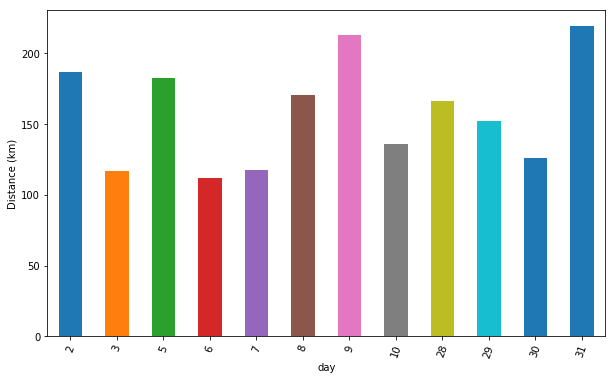

In [187]:
fig, ax = plt.subplots(figsize=[10,6])
tracks_grouped = tracks.groupby(['day'])
tracks_grouped['length'].sum().plot(kind='bar', ax=ax)
xlabels = [text.get_text() for text in  ax.get_xticklabels()]
ax.set_xticklabels(xlabels, rotation=70)
_ = ax.set_ylabel('Distance (km)')

In [232]:
def clear_frame(ax): 
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False) 
    for spine in ax.spines.values(): 
        spine.set_visible(False)

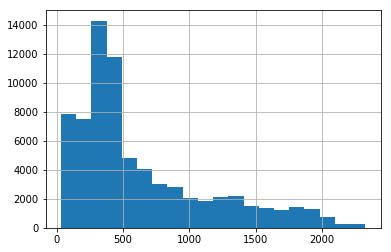

In [227]:
df.elev.hist(bins=20)

In [231]:
df['elev_bins'] = pd.cut(df['elev'], bins = [0, 500, 1000, 1500, 2000], 
                         labels=['0-500', '500-1000', '1000-1500', '1500-2000'])

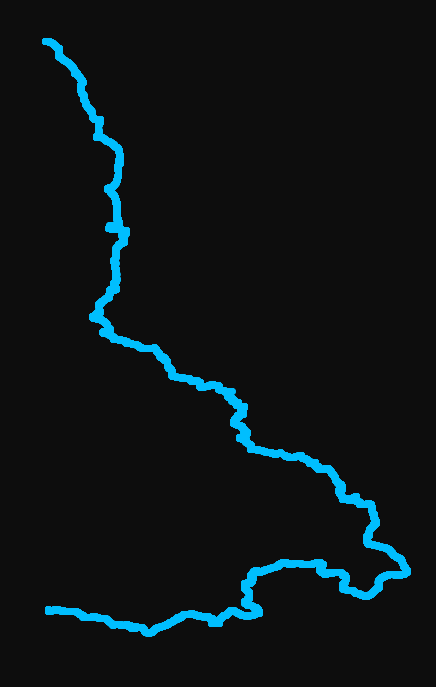

In [234]:
fig,ax = plt.subplots(figsize = [12,12], facecolor = '0.05')
ax.set_aspect('equal')
ax.set_axis_off()
df.plot(color = 'deepskyblue', lw = 0.9, alpha = 0.8, ax=ax)